In [3]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from IPython.display import display_html
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
from wordcloud import WordCloud

In [4]:
train = pd.read_csv('C:\\Users\\Zen\\Documents\\GitHub\\SentimentAnalysis\\data\\twitter_training.csv')
test = pd.read_csv('C:\\Users\\Zen\\Documents\\GitHub\\SentimentAnalysis\\data\\twitter_validation.csv')

In [5]:
train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [7]:
train.columns = ['drop1', 'drop2', 'sentiment', 'content']
test.columns = ['drop1', 'drop2', 'sentiment', 'content']
train.drop(columns=['drop1', 'drop2'],inplace=True)
test.drop(columns=['drop1', 'drop2'],inplace=True)

train.head()

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [8]:
print(f'train shape :{train.shape} | test shape :{test.shape}')

train shape :(74681, 2) | test shape :(999, 2)


In [9]:
x = (train.isnull().sum() / train.shape[0]) * 100
print("Training Data %NAN:")
print(x)
z = (test.isnull().sum() / test.shape[0]) * 100
print("Testing Data %NAN:")
print(z)

Training Data %NAN:
sentiment    0.000000
content      0.918574
dtype: float64
Testing Data %NAN:
sentiment    0.0
content      0.0
dtype: float64


In [10]:
train.dropna(inplace=True)
test.dropna(inplace=True)

org_train = train.copy()
org_test = test.copy()

In [11]:
def clean_text(text):
    text = text.lower() 
    
    text = ' '.join(text.split()) 
    
    text = ' '.join([w for w in text.split() if len(w) > 1 or w in ['a', 'i']])
    
    text = ''.join([c for c in text if c.isalpha() or c.isspace()]) 
    
    stop_words = set(stopwords.words('english')) 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [13]:
data = [train, test]
for df in data:
    df['content'] = df['content'].apply(clean_text)

In [14]:
def lemmatize_and_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    
    tokens = word_tokenize(lemmatized)
    
    return tokens

In [17]:
data = [train, test]
for df in data:
    df['content'] = df['content'].apply(lemmatize_and_tokenize)

In [18]:
train.head()

,sentiment,content
0,Positive,"[coming, border, kill]"
1,Positive,"[im, getting, borderland, kill]"
2,Positive,"[im, coming, borderland, murder]"
3,Positive,"[im, getting, borderland, murder]"
4,Positive,"[im, getting, borderland, murder]"


Preprocessing Done
Data Analysis from here ahead

In [19]:
grouped_tokens = train.groupby('sentiment')['content'].sum()

In [20]:
word_freq = {sentiment: Counter(tokens) for sentiment, tokens in grouped_tokens.items()}

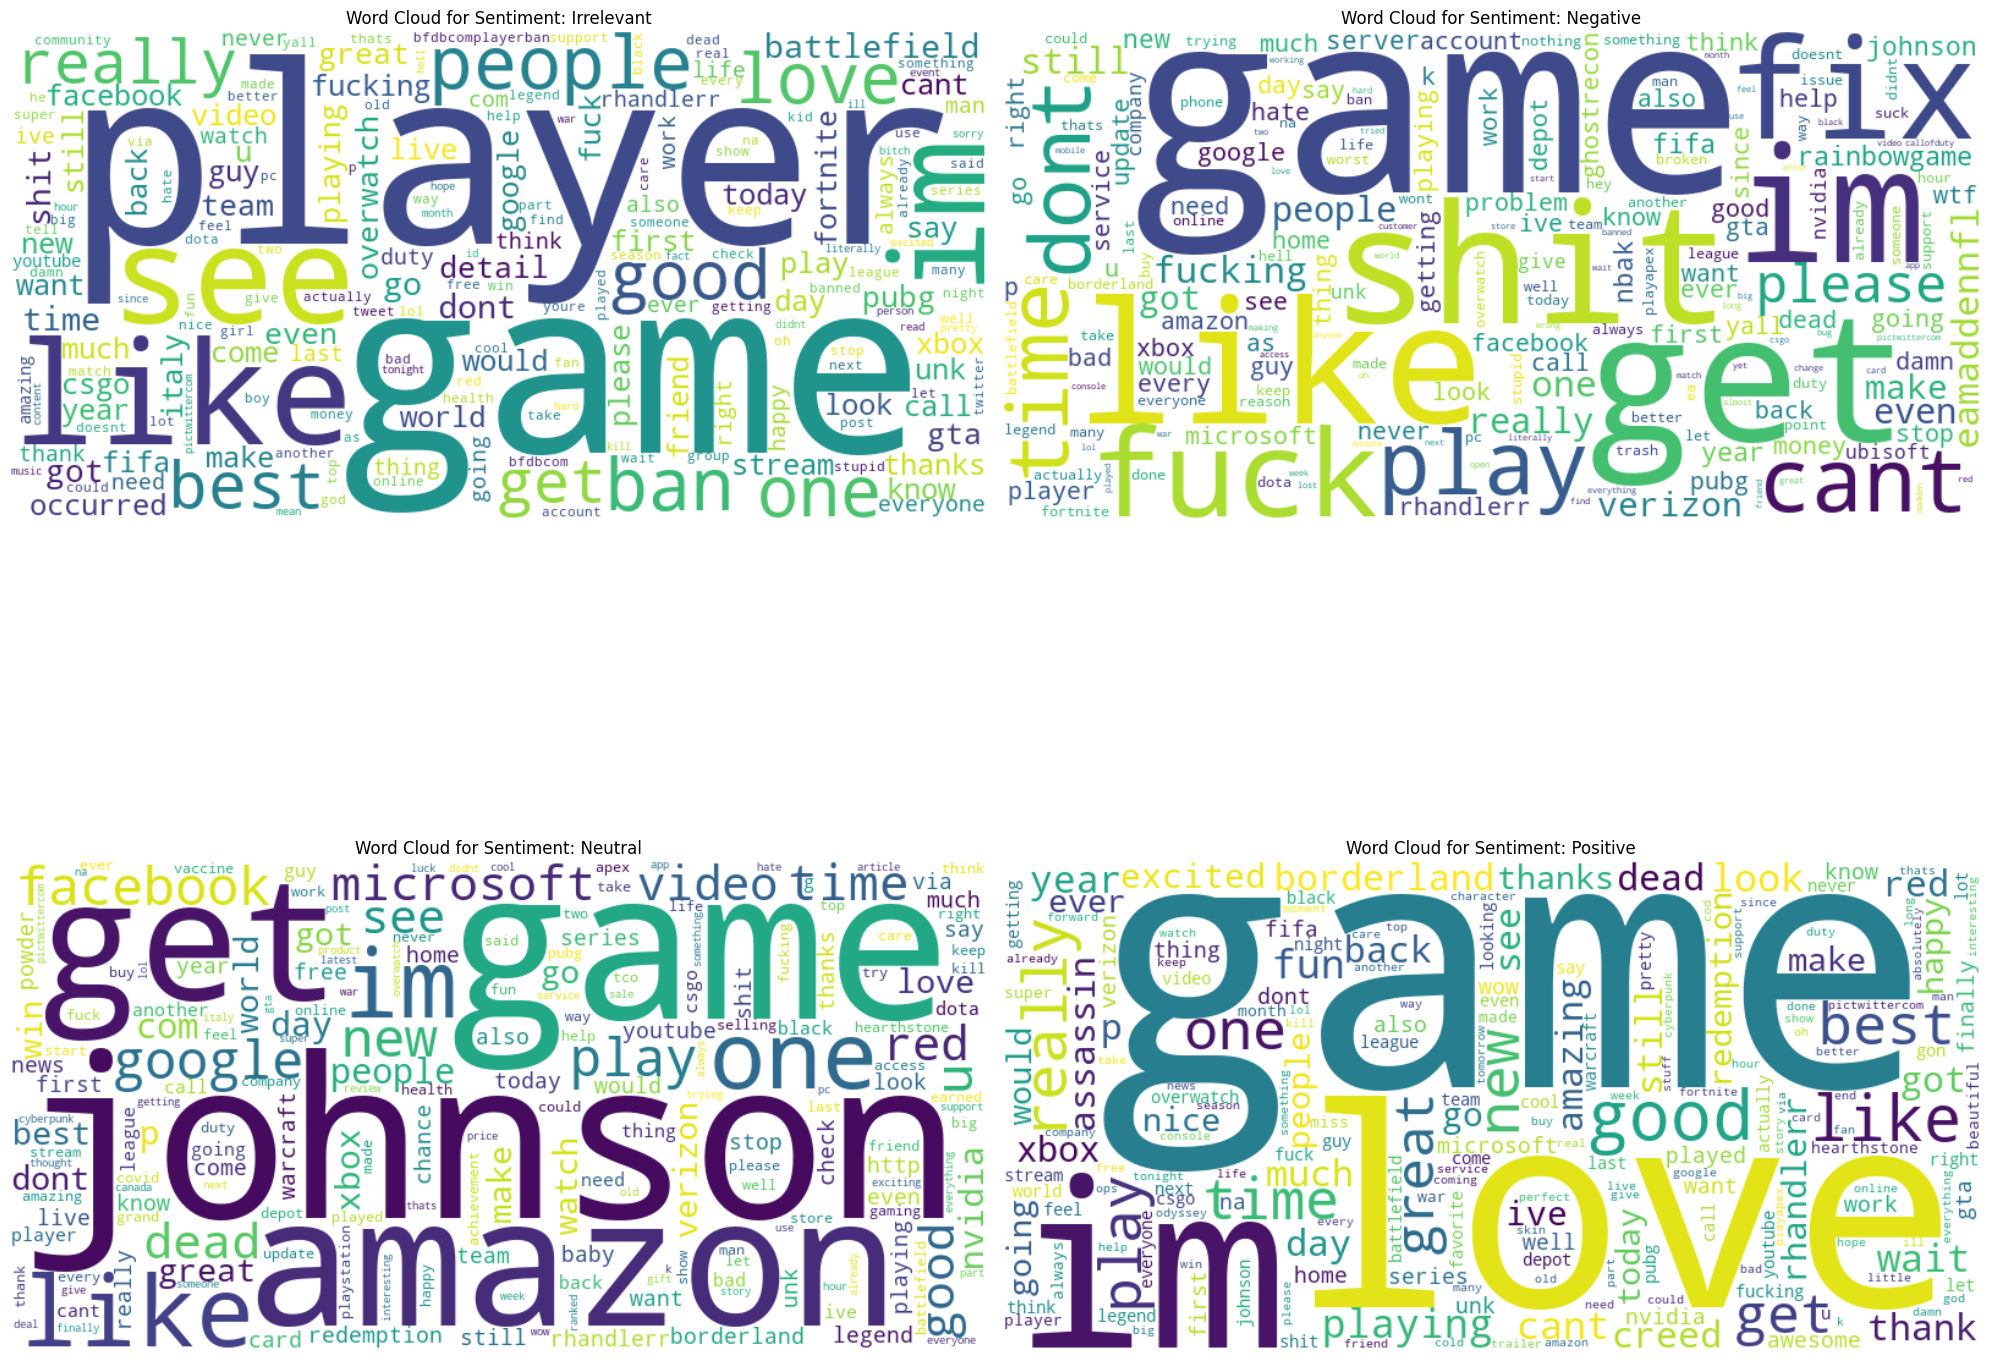

In [21]:
n_sentiments = len(word_freq)
cols = 2  
rows = (n_sentiments + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))  

for i, (sentiment, freq) in enumerate(word_freq.items()):
    ax = axes[i // cols, i % cols] 
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for Sentiment: {sentiment.capitalize()}')

for j in range(i + 1, rows * cols):
    axes[j // cols, j % cols].axis('off')

plt.tight_layout()
plt.show()

In [22]:
full_data = pd.concat([train, test])

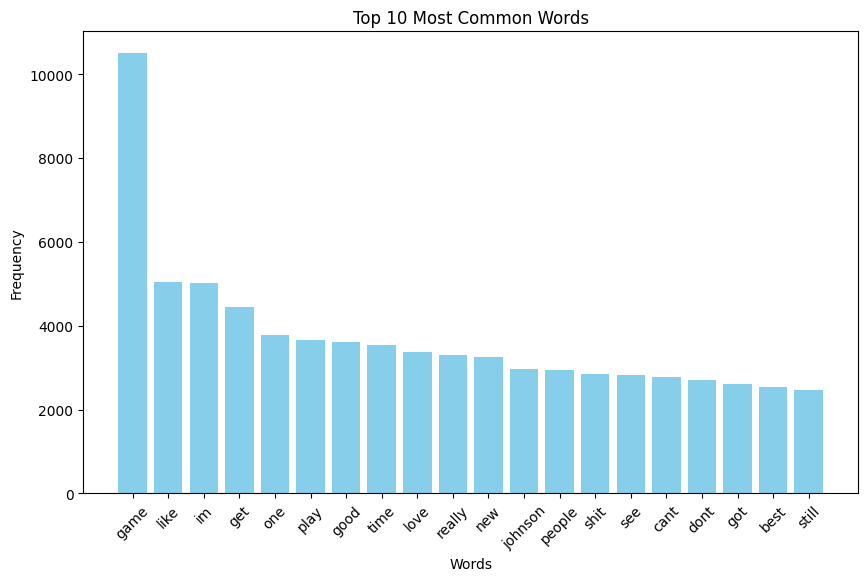

In [23]:
all_tokens = [token for sublist in full_data['content'] for token in sublist]
token_counts = Counter(all_tokens)

most_common_words = token_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [24]:
train['original_text'] = org_train['content'] 
test['original_text'] = org_test['content']

Jaccard similarity score

In [25]:
train['original_length'] = train['original_text'].apply(len)
train['cleaned_length'] = train['content'].apply(lambda x: len(' '.join(x)))

test['original_length'] = test['original_text'].apply(len)
test['cleaned_length'] = test['content'].apply(lambda x: len(' '.join(x)))

In [26]:
def jaccard_similarity_by_count(list1, list2):
    if not list1 and not list2:  
        return 1
    if not list1 or not list2:  
        return 0
    count1 = Counter(list1)
    count2 = Counter(list2)
    intersection = sum((count1 & count2).values())
    union = sum((count1 | count2).values())
    return intersection / union

In [27]:
train['jaccard_score'] = train.apply(lambda row: jaccard_similarity_by_count(row['original_text'].split(), row['content']), axis=1)
test['jaccard_score'] = test.apply(lambda row: jaccard_similarity_by_count(row['original_text'].split(), row['content']), axis=1)

In [28]:
train['jaccard_score'].describe()

count    73995.000000
mean         0.212883
std          0.151336
min          0.000000
25%          0.111111
50%          0.206897
75%          0.297297
max          1.000000
Name: jaccard_score, dtype: float64

In [29]:
zero_jaccard_df = train[train['jaccard_score'] == 0]
zero_jaccard_df.head()

,sentiment,content,original_text,original_length,cleaned_length,jaccard_score
10,Positive,[],was,3,0,0.0
11,Neutral,"[rockhard, la, varlope, rare, powerful, handso...","Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",94,79,0.0
12,Neutral,"[rockhard, la, varlope, rare, powerful, handso...","Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",94,80,0.0
13,Neutral,"[rockhard, la, varlope, rare, powerful, handso...","Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",93,79,0.0
14,Neutral,"[rockhard, la, vita, rare, powerful, handsome,...","Rock-Hard La Vita, RARE BUT POWERFUL, HANDSOME...",91,76,0.0


MODELNG

In [30]:
train_filtered = train[train['sentiment'].isin(['Positive', 'Negative'])]
test_filtered = test[test['sentiment'].isin(['Positive', 'Negative'])]

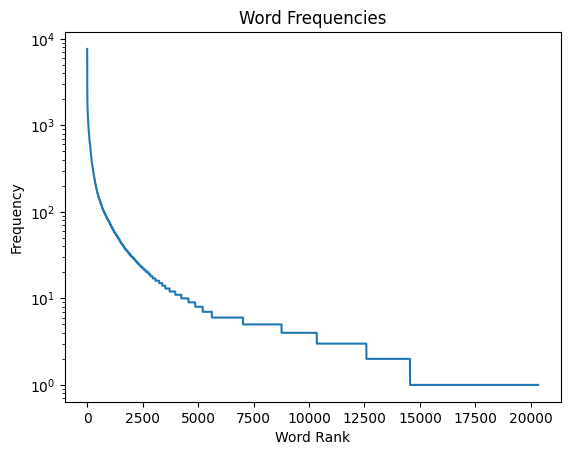

In [31]:
all_tokens = [token for sublist in train_filtered['content'] for token in sublist]
word_freq = Counter(all_tokens)

frequencies = list(word_freq.values())
frequencies.sort(reverse=True)

plt.plot(frequencies)
plt.title('Word Frequencies')
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.yscale('log')  
plt.show()

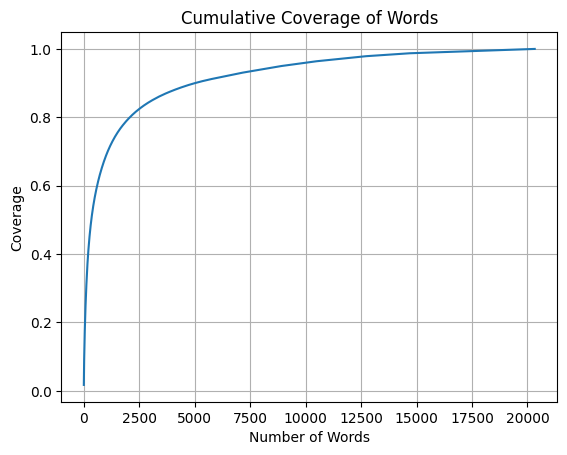

Coverage with top 1000 words: 68.77%
Coverage with top 5000 words: 89.98%
Coverage with top 7000 words: 92.88%
Coverage with top 10000 words: 95.98%
Coverage with top 15000 words: 98.80%
Coverage with top 20000 words: 99.93%


In [32]:
total_occurrences = sum(word_freq.values())
cumulative_counts = np.cumsum(sorted(word_freq.values(), reverse=True))
cumulative_coverage = cumulative_counts / total_occurrences

plt.plot(cumulative_coverage)
plt.title('Cumulative Coverage of Words')
plt.xlabel('Number of Words')
plt.ylabel('Coverage')
plt.grid(True)
plt.show()

for i in [1000, 5000, 7000, 10000, 15000, 20000]:
    coverage = cumulative_coverage[i] if i < len(cumulative_coverage) else cumulative_coverage[-1]
    print(f"Coverage with top {i} words: {coverage:.2%}")

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_size = 7000

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')

all_tokens = [token for sublist in pd.concat([train_filtered['content'], test_filtered['content']]) for token in sublist]
tokenizer.fit_on_texts(all_tokens)

train_filtered['content'] = tokenizer.texts_to_sequences(train_filtered['content'])
test_filtered['content'] = tokenizer.texts_to_sequences(test_filtered['content'])

C:\Users\Zen\AppData\Local\Temp\ipykernel_26944\4120232982.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['content'] = tokenizer.texts_to_sequences(train_filtered['content'])
C:\Users\Zen\AppData\Local\Temp\ipykernel_26944\4120232982.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['content'] = tokenizer.texts_to_sequences(test_filtered['content'])


In [34]:
vectorized_train = train_filtered.copy()
vectorized_test = test_filtered.copy()

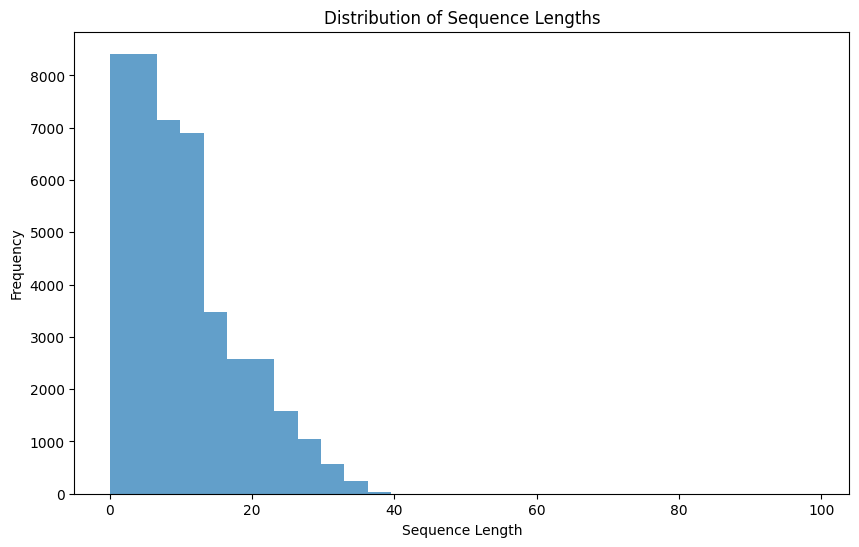

Mean length:  10.309681019250442
Median length:  8.0
Max length:  99
Min length:  0


In [35]:
lengths = [len(v) for v in vectorized_train['content']]

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, alpha=0.7)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

import numpy as np

print("Mean length: ", np.mean(lengths))
print("Median length: ", np.median(lengths))
print("Max length: ", np.max(lengths))
print("Min length: ", np.min(lengths))

In [36]:
max_length = int(np.percentile(lengths, 95))
print("95th percentile length: ", max_length)

95th percentile length:  26


In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import ast

In [38]:

vectorized_train['content'] = vectorized_train['content'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
vectorized_test['content'] = vectorized_test['content'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [39]:
vectorized_train = vectorized_train[vectorized_train['content'].apply(len) > 0]
vectorized_train.reset_index(drop=True, inplace=True)

vectorized_test = vectorized_test[vectorized_test['content'].apply(len) > 0]
vectorized_test.reset_index(drop=True, inplace=True)

In [40]:
X = pad_sequences(vectorized_train['content'], maxlen=max_length, padding='post', dtype='float32')
X_test2 = pad_sequences(vectorized_test['content'], maxlen=max_length, padding='post', dtype='float32')

In [41]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(vectorized_train['sentiment']) 
y_test2 = label_encoder.fit_transform(vectorized_test['sentiment']) 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
vocab_size = 7000
embedding_dim = 50  
max_length = 26  

In [ ]:
#optuna??????